In [1]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import KFold
from selfregulation.utils.r_to_py_utils import GPArotation, missForest, psychFA
from fancyimpute import SoftImpute
%matplotlib inline

Using TensorFlow backend.


# Calculate best number of components based on CV ML (SKlearn)

### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [2]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

In [3]:
# load data
data = get_behav_data(file = 'taskdata_clean.csv', full_dataset = True)
# imputed data
imputed_data = get_behav_data(dataset = 'Complete_12-15-2016', file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(dataset = 'Complete_12-15-2016', file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}
# cleaned data 
cleaned_data = get_behav_data(dataset = 'Complete_12-15-2016', file = 'meaningful_variables_clean.csv')
cleaned_task_data = get_behav_data(dataset = 'Complete_12-15-2016', file = 'taskdata_clean.csv')
cleaned_survey_data = cleaned_data.drop(cleaned_task_data.columns, axis = 1)
cleaned_datasets = {'survey': cleaned_survey_data, 'task': cleaned_task_data, 'complete': cleaned_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-16-2017
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Validation_01-16-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_12-15-2016
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_12-15-2016
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_12-15-2016
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_12-15-2016


### Determine optimal number of factors
Two methods

Sklearn using cross-validated prediction
R's Psych package looking for best fitting model across all the data, penalized for complexity (BIC)

Dataset: task
Best Component:  7
Dataset: complete
Best Component:  8
Dataset: survey
Best Component:  10


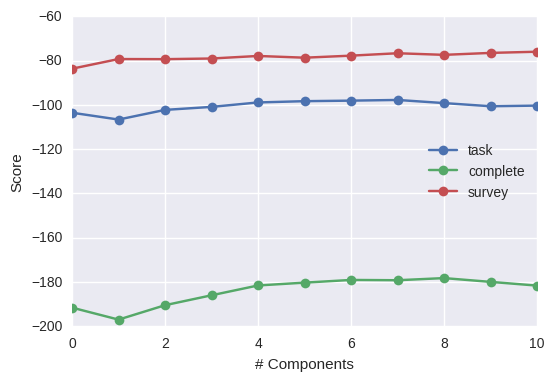

In [4]:
def CV_optimal_components(data, cv):
    # find best number of components
    n_components = range(1,12)
    best_c = 0
    component_scores = []
    for c in n_components:
        fa=FactorAnalysis(c)
        scores = []
        # cross-validate fit across different train/test splits
        for train_index, test_index in kf.split(data.values):
            data_train, data_test = data.iloc[train_index], \
                                    data.iloc[test_index]
            # Impute (replace with missForest later)
            imputed_train = SoftImpute_df(data_train)
            imputed_test = SoftImpute_df(data_test)
            # fit model on training
            fa.fit(imputed_train)
            # score on test set
            scores.append(fa.score(imputed_test))
        #average score across kfolds
        score = np.mean(scores)
        component_scores.append(score)
    best_c = np.argmax(component_scores)
    print('Best Component: ', best_c)
    return best_c, component_scores

kf = KFold(n_splits = 4)
for label,data in cleaned_datasets.items():
    print('Dataset: %s' % label)
    best_c, scores= CV_optimal_components(data, kf)
    results[label]['sklearn_best_c'] = best_c
    results[label]['CV_scores'] = scores
    
for score in [d['CV_scores'] for d in results.values()]:
    plt.plot(range(len(score)),score, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

### Calculate best number of components using BIC (R Psych package)

Dataset: task


/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)


Best Component:  6
Dataset: complete
Best Component:  9
Dataset: survey
Best Component:  10


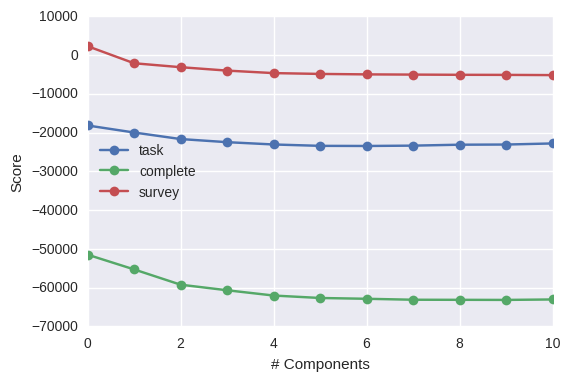

In [5]:
def BIC_optimal_components(data):
    BICs = []
    outputs = []
    n_components = range(1,12)
    for c in n_components:
        fa, output = psychFA(data, c)
        BICs.append(output['BIC'])
        outputs.append(output)
    best_c = np.argmin(BICs)
    print('Best Component: ', best_c)
    return best_c, BICs

for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = BIC_optimal_components(data)
    results[label]['psych_best_c'] = best_c
    results[label]['psych_BICs'] = BICs
    
for bic in [d['psych_BICs'] for d in results.values()]:
    plt.plot(range(len(bic)),bic, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

# Interpret Task Factor Analysis Solution
Above we found that the best number of components were as follows:

**SKlearn**:

Task: {{results['task']['sklearn_best_c']}}

Survey: {{results['survey']['sklearn_best_c']}}

Complete: {{results['complete']['sklearn_best_c']}}

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

Because psych performs rotation, is more widely used, we will use that as our main analysis. All analyses will be repeated with the sklearn pipeline as well. First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

### Interpret best components

In [6]:
task_results = results['task']
best_c = task_results['psych_best_c']
data = imputed_datasets['task']
fa, output = psychFA(data, best_c)

In [7]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 6)


FACTOR 0
choice_reaction_time.hddm_drift      0.797634
shape_matching.hddm_drift            0.688741
simon.hddm_drift                     0.680350
dot_pattern_expectancy.hddm_drift    0.652253
stop_signal.hddm_drift               0.649992
directed_forgetting.hddm_drift       0.606682
Name: 0, dtype: float64

FACTOR 1
adaptive_n_back.mean_load                         0.648858
adaptive_n_back.hddm_drift                        0.580791
spatial_span.reverse_span                         0.553749
spatial_span.forward_span                         0.550134
cognitive_reflection_survey.correct_proportion    0.533210
ravens.score                                      0.493185
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.hddm_non_decision    0.612371
attention_network_task.hddm_non_decision         0.573814
simon.hddm_non_decision                          0.572454
stop_signal.SSRT_high                            0.553527
stop_signal.SSRT_low                             0.552724
ch

### Histogram of factor loadings and plot of histogram relationship
We can see that factors 4 and 5 are really just pulling from a few variables. They are really "task" factors - tapping discounting tasks and the ART task respectively. The CCT Hot "number of cards chosen" maps onto factor 5, but to a far smaller extent

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45ffb63e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f45ff7682b0>]], dtype=object)

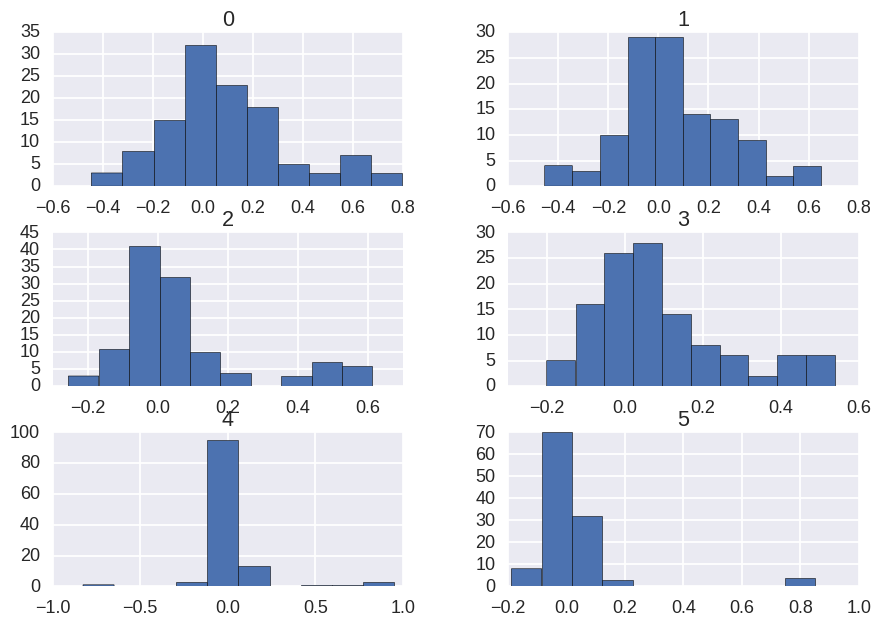

In [8]:
sns.set_context('talk')
loading_df.hist()

The factors are roughly orthogonal. Orthogonality wasn't enforced, and factors were rotated using "oblimin"

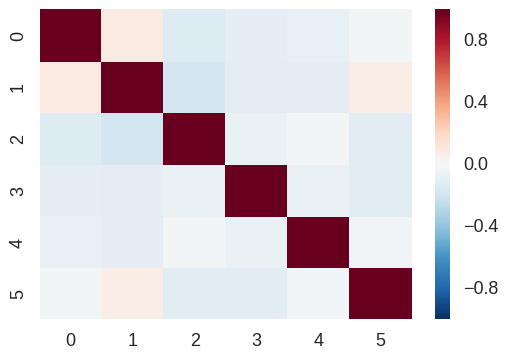

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(loading_df.corr())

### Interpretation/Naming of Factors 

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Response Caution (Threshold)

Factor 4: Dicount Rate

Factor 5: Risk Taking

## Do the same for all other dimensionalities

In [10]:
factor_names = {}

**One Factor**

Factor 0: Cognitive Ability

In [11]:
fa, output = psychFA(data, 1)
loading_df = print_top_factors(output)
factor_names[1] = ['CogAblty']


FACTOR 0
threebytwo.hddm_drift             0.690205
directed_forgetting.hddm_drift    0.638651
adaptive_n_back.mean_load         0.626469
ravens.score                      0.626214
Name: 0, dtype: float64


**Two Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Discount Rate

In [12]:
fa, output = psychFA(data, 2)
loading_df = print_top_factors(output, 6)
factor_names[2] = ['Drift','Discount']


FACTOR 0
threebytwo.hddm_drift                0.702483
directed_forgetting.hddm_drift       0.701207
dot_pattern_expectancy.hddm_drift    0.694666
choice_reaction_time.hddm_drift      0.670296
simon.hddm_drift                     0.643229
recent_probes.hddm_drift             0.639076
Name: 0, dtype: float64

FACTOR 1
kirby.hyp_discount_rate_small.logTr               0.930875
kirby.hyp_discount_rate_medium.logTr              0.915449
kirby.hyp_discount_rate_large.logTr               0.889102
discount_titrate.percent_patient                 -0.827890
bickel_titrator.hyp_discount_rate_medium.logTr    0.693354
bickel_titrator.hyp_discount_rate_large.logTr     0.517001
Name: 1, dtype: float64


**Three Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Encoding Time (Non-Decision)

Factor 2: Discount Rate

In [13]:
fa, output = psychFA(data, 3)
loading_df = print_top_factors(output, 6)
factor_names[3] = ['Drift','Non-Dec','Discount']


FACTOR 0
threebytwo.hddm_drift                0.703120
dot_pattern_expectancy.hddm_drift    0.696188
directed_forgetting.hddm_drift       0.694761
choice_reaction_time.hddm_drift      0.691004
simon.hddm_drift                     0.667436
stop_signal.hddm_drift               0.633982
Name: 0, dtype: float64

FACTOR 1
shape_matching.hddm_non_decision            0.518774
tower_of_london.avg_move_time               0.513429
recent_probes.hddm_non_decision             0.497421
attention_network_task.hddm_non_decision    0.493765
simon.hddm_non_decision                     0.487786
stroop.hddm_non_decision                    0.477281
Name: 1, dtype: float64

FACTOR 2
kirby.hyp_discount_rate_small.logTr               0.899093
kirby.hyp_discount_rate_medium.logTr              0.888203
kirby.hyp_discount_rate_large.logTr               0.879032
discount_titrate.percent_patient                 -0.834151
bickel_titrator.hyp_discount_rate_medium.logTr    0.702829
bickel_titrator.hyp_discount_rate

**Four Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Encoding Time (Non-Decision)

Factor 3: Discount Rate

In [14]:
fa, output = psychFA(data, 4)
loading_df = print_top_factors(output, 6)
factor_names[4] = ['Drift','Mem','Non-Dec','Discount']


FACTOR 0
choice_reaction_time.hddm_drift           0.744881
stop_signal.hddm_drift                    0.694226
simon.hddm_drift                          0.687702
shape_matching.hddm_drift                 0.654776
dot_pattern_expectancy.hddm_drift         0.630557
motor_selective_stop_signal.hddm_drift    0.626186
Name: 0, dtype: float64

FACTOR 1
adaptive_n_back.mean_load                         0.609246
cognitive_reflection_survey.correct_proportion    0.579291
spatial_span.forward_span                         0.555796
ravens.score                                      0.545280
adaptive_n_back.hddm_drift                        0.528406
spatial_span.reverse_span                         0.511955
Name: 1, dtype: float64

FACTOR 2
simon.hddm_non_decision                          0.542066
recent_probes.hddm_non_decision                  0.515235
stroop.hddm_non_decision                         0.510139
shape_matching.hddm_non_decision                 0.507694
attention_network_task.hddm_no

**Five Factors**

Factor 0: Speed of Processing (Drfit)

Factor 1: Memory/Abstraction 

Factor 2: Encoding Time (Non-Decision)

Factor 3: Response Caution (Threshold)

Factor 4: Discount Rate

In [15]:
fa, output = psychFA(data, 5)
loading_df = print_top_factors(output, 6)
factor_names[5] = ['Drift','Mem','Non-Dec','Thresh','Discount']


FACTOR 0
choice_reaction_time.hddm_drift      0.787855
shape_matching.hddm_drift            0.696617
simon.hddm_drift                     0.677757
dot_pattern_expectancy.hddm_drift    0.660450
stop_signal.hddm_drift               0.649928
directed_forgetting.hddm_drift       0.621092
Name: 0, dtype: float64

FACTOR 1
adaptive_n_back.mean_load                         0.612685
cognitive_reflection_survey.correct_proportion    0.578158
spatial_span.forward_span                         0.553909
ravens.score                                      0.545772
adaptive_n_back.hddm_drift                        0.523774
spatial_span.reverse_span                         0.516017
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.hddm_non_decision    0.610784
attention_network_task.hddm_non_decision         0.576721
simon.hddm_non_decision                          0.570750
stop_signal.SSRT_high                            0.556045
stop_signal.SSRT_low                             0.554953
ch

**Six Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Response Caution (Threshold)

Factor 4: Dicount Rate

Factor 5: Risk Taking

In [16]:
fa, output = psychFA(data, 6)
loading_df = print_top_factors(output)
factor_names[6] = ['Drift','Mem','Non-Dec','Thresh','Discount','Risk']


FACTOR 0
choice_reaction_time.hddm_drift      0.797634
shape_matching.hddm_drift            0.688741
simon.hddm_drift                     0.680350
dot_pattern_expectancy.hddm_drift    0.652253
Name: 0, dtype: float64

FACTOR 1
adaptive_n_back.mean_load     0.648858
adaptive_n_back.hddm_drift    0.580791
spatial_span.reverse_span     0.553749
spatial_span.forward_span     0.550134
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.hddm_non_decision    0.612371
attention_network_task.hddm_non_decision         0.573814
simon.hddm_non_decision                          0.572454
stop_signal.SSRT_high                            0.553527
Name: 2, dtype: float64

FACTOR 3
shape_matching.hddm_thresh                 0.539046
simon.hddm_thresh                          0.524926
local_global_letter.hddm_thresh            0.518721
motor_selective_stop_signal.hddm_thresh    0.509523
Name: 3, dtype: float64

FACTOR 4
kirby.hyp_discount_rate_small.logTr     0.947289
kirby.hyp_discount_rate_m

**Seven Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Information Use

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Dicount Rate

Factor 4: Response Caution (Threshold)

Factor 5: Response Caution (Speed of action)

Factor 6: Risk Taking

In [17]:
fa, output = psychFA(data, 7)
loading_df = print_top_factors(output, 8)
factor_names[7] = ['Drift','Inf-Use','Non-Dec','Discount','Thresh','Speed', 'Risk']


FACTOR 0
choice_reaction_time.hddm_drift           0.775411
simon.hddm_drift                          0.713011
stop_signal.hddm_drift                    0.696627
shape_matching.hddm_drift                 0.694164
dot_pattern_expectancy.hddm_drift         0.647852
stim_selective_stop_signal.hddm_drift     0.642268
threebytwo.hddm_drift                     0.630646
motor_selective_stop_signal.hddm_drift    0.618789
Name: 0, dtype: float64

FACTOR 1
columbia_card_task_hot.information_use            0.610768
columbia_card_task_hot.loss_sensitivity          -0.543181
columbia_card_task_cold.information_use           0.541362
columbia_card_task_hot.gain_sensitivity           0.502019
adaptive_n_back.mean_load                         0.473825
ravens.score                                      0.468719
cognitive_reflection_survey.correct_proportion    0.449960
columbia_card_task_cold.gain_sensitivity          0.433732
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.hddm_non_decis

**Eight Factors**

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Dicount Rate

Factor 4: Response Caution (Threshold)

Factor 5: Risk Taking

Factor 6: Information Use (CCT information)

Factor 7: Response Caution (Speed of action on IST and TOL)


In [18]:
fa, output = psychFA(data, 8)
loading_df = print_top_factors(output, 6)
factor_names[8] = ['Drift','Mem','Non-Dec','Discount','Thresh','Risk','Inf-Use','Speed']


FACTOR 0
choice_reaction_time.hddm_drift          0.743173
stop_signal.hddm_drift                   0.702812
simon.hddm_drift                         0.683427
shape_matching.hddm_drift                0.662477
stim_selective_stop_signal.hddm_drift    0.628049
stroop.hddm_drift                        0.602784
Name: 0, dtype: float64

FACTOR 1
ravens.score                                      0.625303
adaptive_n_back.mean_load                         0.606866
cognitive_reflection_survey.correct_proportion    0.542445
adaptive_n_back.hddm_drift                        0.523075
spatial_span.reverse_span                         0.491270
digit_span.reverse_span                           0.485729
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.hddm_non_decision    0.624591
simon.hddm_non_decision                          0.613980
stroop.hddm_non_decision                         0.553390
choice_reaction_time.hddm_non_decision           0.542577
attention_network_task.hddm_non_deci

### Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [19]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*4
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 50, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [20]:
# construct array of component similarities
similarities = []
components = np.sort(list(factor_names.keys()))
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result




In [21]:
# plot component similarity tree
labels = []
for c in components:
    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, labels=labels, filey=path.join('Plots', 'task_graph.png'))

# Scrap

In [22]:
for label,data in imputed_datasets.items():
    best_c = task_data['sklearn_best_c']
    # construct array of component similarities
    similarities = []
    components = range(1,best_c+2)
    reference = None
    for c in components:
        fa=FactorAnalysis(c)
        result = pd.DataFrame(fa.fit_transform(data.values), data.index)
        if c>1:
            result = GPArotation(result, method='oblimin')
        if reference is not None:
            similarity = dimensional_similarity(result,reference)
            similarities.append(similarity)
        reference = result

    # plot tree
    labels = []
    for c in np.sort(list(factor_names.keys())):
        labels+=factor_names[c]
    similarity_tree = construct_relational_tree(similarities, filey=path.join('Plots', + label +'_graph.png'))


NameError: name 'task_data' is not defined

In [ ]:
"""
# Take max for each dimension?
binarized_similarities = []
for s in similarities:
    r,c = s.shape
    binarized_similarities.append(s==np.resize(s.max(axis=1),(c,r)).T)
"""
thresh = .5
binarized_similarities = []
for s in similarities:
    binarized_similarities.append((s>thresh)*1)

## Visualization of optimal factor structure

### Sum over task variables (extrememly questionable) and then plot the relationships across tasks

In [ ]:
from plot_utils import dendroheatmap_left
# *****************************************************************************
# sum over tasks
# *****************************************************************************
tasks = np.unique([i.split('.')[0] for i in data.columns])
task_sums = {}
for task in tasks:  
    task_sums[task] = result.filter(regex=task,axis=0).sum()
task_sums = pd.DataFrame(task_sums).T
dendroheatmap = dendroheatmap_left(task_sums.T.corr())

### multidimensional scaling

In [ ]:
# *****************************************************************************
# visualize the similarity of the measurements in FA space
# *****************************************************************************

from data_preparation_utils import convert_var_names
from graph_utils import distcorr_mat
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import seaborn as sns

seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

tsne = manifold.TSNE(n_components=2, random_state=seed, metric="precomputed")

# compute distances between variables
# using distance correlation
# result_distances = 1-distcorr_mat(result.T.values)
# euclidean
result_distances = euclidean_distances(result)
# transform
mds_transform = mds.fit_transform(result_distances)
tsne_transform = tsne.fit_transform(result_distances)

# plot
tasks = [i.split('.')[0] for i in result.index]
colors = sns.color_palette("husl", len(np.unique(tasks)))

fig, ax = sns.plt.subplots(figsize = (20,20))
ax.scatter(mds_transform[:,0], mds_transform[:,1])

variables = convert_var_names(list(result.index))
for i, txt in enumerate(variables):
    ax.annotate(txt, (mds_transform[i,0],mds_transform[i,1]), size = 15)
